# 2. Confined Aquifer Test - Gridley

### Import packages

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import timflow.transient as tft

plt.rcParams["figure.figsize"] = (5, 3)  # default figure size

### Introduction and Conceptual Model

This example is a pumping test conducted in 1953 in Gridley, Illinois, US. It was reported by Walton (1962). 

The aquifer is an 18 ft thick sand and gravel layer under confined conditions. The pumping well fully penetrates the formation, and pumping was conducted for 8 hours at a rate of 220 gallons per minute. The effect of pumping was observed at observation well 1, located 824 ft away from the well.

The time-drawdown data for the observation well were obtained from the AQTESOLV documentation (Duffield, 2007), while data from the pumping well were obtained from the original paper from Walton (1962). Following AQTESOLV documentation (Duffield, 2007), radii of 0.5 ft were used for both the pumping and observation wells. 

<img src="./figs/gridley.png" style="width:400pt">

### Load data

In [10]:
# Loading Observation well (Well 1)
data1 = np.loadtxt("data/gridley_well_1.txt")
to1 = data1[:, 0]
ho1 = data1[:, 1]

# Loading Pumping Well data (Well 3)
data2 = np.loadtxt("data/gridley_well_3.txt")
to2 = data2[:, 0]
ho2 = data2[:, 1]

### Parameters and model

In [13]:
# known parameters
H = 18 * 0.3048  # aquifer thickness in m (18 ft = 5.48 m)
Q = (220 * 0.00378541) * 60 * 24  # constant discharge in m^3/d (220 gallons/minute = 1199.22 m^3/d)
r = 824 * 0.3048  # distance between observation well to test well in m (824 ft = 251.16 m)
rw = 0.5 * 0.3048 # screen radius of test well in m (0.5 ft = 0.15 m)

Wellbore storage is added to the model.

In [18]:
ml = tft.ModelMaq(kaq=10, z=[0, -H], Saq=0.001, tmin=0.001, tmax=1, topboundary="conf")
w = tft.Well(ml, xw=0, yw=0, rw=rw, tsandQ=[(0, Q)],rc=rw , layers=0) 
ml.solve()

self.neq  1
solution complete


### Estimate aquifer parameters

The aquifer parameters are estimated using both datasets simultaneously.

In [20]:
# unknown parameters: kaq, Saq
cal = tft.Calibrate(ml)  # create Calibrate object
cal.set_parameter(name="kaq", initial=10, layers=0)  # setting the parameters for calibration
cal.set_parameter(name="Saq", initial=1e-4, pmin=1e-7, layers=0)
cal.series(name="obs1", x=r, y=0, t=to1, h=ho1, layer=0)  # setting the observation data
cal.seriesinwell(name="obs2", element=w, t=to2, h=ho2)  # setting the observation data
cal.fit(report=True)

...........................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24
    # data points      = 36
    # variables        = 2
    chi-square         = 2.41063000
    reduced chi-square = 0.07090088
    Akaike info crit   = -93.3307093
    Bayesian info crit = -90.1636715
[[Variables]]
    kaq_0_0:  38.0863413 +/- 0.50173392 (1.32%) (init = 10)
    Saq_0_0:  1.1935e-06 +/- 1.8556e-07 (15.55%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq_0_0, Saq_0_0) = -0.7708


In [22]:
display(cal.parameters)
print("RMSE:", cal.rmse())

,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq_0_0,0,38.086341,5.017339e-01,1.317359,-inf,inf,10.0000,None,[[38.08634128836749]]
Saq_0_0,0,0.000001,1.855625e-07,15.547240,1.000000e-07,inf,0.0001,None,[[1.1935399729656737e-06]]


RMSE: 0.25876996507559114


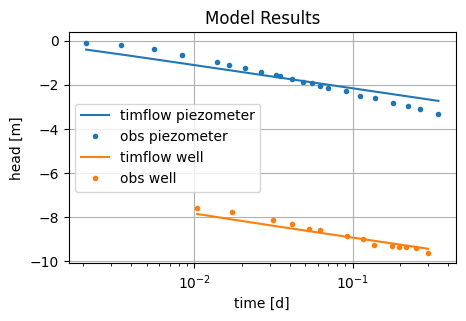

In [36]:
hm1 = ml.head(r, 0, to1)
hm2 = w.headinside(to2)
plt.semilogx(to1, hm1[0], 'C0', label="timflow piezometer")
plt.semilogx(to1, ho1, "C0.", label="obs piezometer")
plt.semilogx(to2, hm2[0], 'C1', label="timflow well")
plt.semilogx(to2, ho2, "C1.", label="obs well")
plt.title("Model Results")
plt.xlabel("time [d]")
plt.ylabel("head [m]")
plt.legend()
plt.grid()

### Comparison of results

The performance of `timflow` with two datasets simultaneously was evaluated by comparison with AQTESOLV (Duffield, 2007), and MLU (Carlson and Randall, 2012). Results from `timflow` with added welbore storage and MLU are identical, while those from AQTESOLV show small deviations.

In [34]:
t = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "RMSE [m]"], 
    index=["timflow", "AQTESOLV", "MLU"]
)

t.loc["timflow"] = np.append(cal.parameters["optimal"].values, cal.rmse())
t.loc["MLU"] = [38.094, 1.193e-06, 0.259]
t.loc["AQTESOLV"] = [37.803, 1.356e-06, 0.270]

t_formatted = t.style.format(
    {"k [m/d]": "{:.2f}", 
    "Ss [1/m]": "{:.2e}",  
    "RMSE [m]": "{:.3f}"}
)
t_formatted

,k [m/d],Ss [1/m],RMSE [m]
timflow,38.09,1.19e-06,0.259
AQTESOLV,37.80,1.36e-06,0.270
MLU,38.09,1.19e-06,0.259


## References

* Carlson, F. and Randall, J. (2012), MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems, Ground Water 50(4):504–510
* Duffield, G.M. (2007), AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Walton, W.C. (1962), Selected analytical methods for well and aquifer evaluation, Illinois, department of Registration & Education.bulletin 49.